### Setup

In [461]:
import yaml
import pathlib
import pickle as pk

import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import umap
from sklearn.decomposition import PCA

from cplAE_MET.models.model_classes import MultiModal

In [2]:
# This functions aligns a target array with the passed annotation dataframe using specimen ids
def align(array, specimen_ids, anno):
    aligned_array = np.stack([np.full_like(array[0], np.nan)] * len(anno))
    id_df = pd.DataFrame(data = {"specimen_id": specimen_ids, "alignment_index": range(len(specimen_ids))})
    id_df["specimen_id"] = id_df["specimen_id"].str.strip()
    aligned_indices = pd.merge(anno, id_df, on = "specimen_id", how = "inner")
    aligned_array[aligned_indices["row_index"].to_numpy()] =  array[aligned_indices["alignment_index"].to_numpy()]
    return aligned_array

# This function selects data from the target array based on which rows are present in the passed annotation
def select(array, anno):
    selected = array[anno["row_index"]]
    return selected

# This function samples from the passed dataframes to ensure that there is an equal number of samples
# from each experiment across excitatory cells and inhibitory cells
def normalize_sample_count(exp1, exp2, anno):
    unnormalized = anno.query("platform == @exp1 or platform == @exp2")
    exp1_exc = unnormalized.query("platform == @exp1 and `class` == 'exc'")
    exp1_inh = unnormalized.query("platform == @exp1 and `class` == 'inh'")
    exp2_exc = unnormalized.query("platform == @exp2 and `class` == 'exc'")
    exp2_inh = unnormalized.query("platform == @exp2 and `class` == 'inh'")
    if len(exp1_exc) > len(exp2_exc):
       exp1_exc = exp1_exc.sample(len(exp2_exc), replace = False)
    else:
        exp2_exc = exp2_exc.sample(len(exp1_exc), replace = False)
    if len(exp1_inh) > len(exp2_inh):
       exp1_inh = exp1_inh.sample(len(exp2_inh), replace = False)
    else:
        exp2_inh = exp2_inh.sample(len(exp1_inh), replace = False)
    anno_samp = pd.concat([exp1_exc, exp1_inh, exp2_exc, exp2_inh])
    return (unnormalized, anno_samp)

def load_model(exp_dir):
    exp_dir = pathlib.Path(exp_dir)
    with open(exp_dir / "config.yaml", "r") as target:
        config = yaml.safe_load(target)
    config["gauss_e_baseline"] = 1
    config["gauss_m_baseline"] = 1
    model = MultiModal(config)
    best_state = torch.load(exp_dir / "best_params.pt", map_location = torch.device("cpu"))
    model.load_state_dict(best_state)
    return model

### Load Data

In [3]:
# Load cell annotation file
anno_full = pd.read_csv("../data/raw/exc_inh_ME_fMOST_EM_specimen_ids_shuffled_4Apr23.txt").rename(columns = {"Unnamed: 0": "row_index"})
anno_full["specimen_id"] = anno_full["specimen_id"].str.strip()
# Load arbor density data (generated by data_proc_M.py in Fahimeh's cplAE_MET repository)
arbor_dict = sio.loadmat("../data/raw/M_arbor_data_50k_4Apr23.mat")
arbors = align(arbor_dict["hist_ax_de_api_bas"], arbor_dict["specimen_id"], anno_full) # Always align with unfiltered annotation
# Filter out cells which do not have valid morphological data
anno = anno_full.query("M_cell")
anno

row_index                specimen_id platform class  group  class_id  \
0              0  864691135274125285_199010       EM   exc      1       0.0   
2              2  864691135212658304_427884       EM   exc      1       0.0   
3              3  864691135354962383_392595       EM   exc      1       0.0   
5              5  864691136656750077_610633       EM   exc      1       0.0   
6              6  864691136898656366_396172       EM   exc      1       0.0   
...          ...                        ...      ...   ...    ...       ...   
52252      52252  864691135750158472_388862       EM   exc      1       0.0   
52254      52254  864691135373371848_297143       EM   exc      1       0.0   
52255      52255  864691135714363796_557060       EM   exc      1       0.0   
52256      52256  864691135587516402_491694       EM   exc      1       0.0   
52257      52257  864691136617413083_116088       EM   exc      1       0.0   

       T_cell  E_cell  M_cell  subgroup proofread  
0       False   False    True         1       NaN  
2       False   False    True         1       NaN  
3       False   False    True         1       NaN  
5       False   False    True         1       NaN  
6       False   False    True         1       NaN  
...       ...     ...     ...       ...       ...  
52252   False   False    True         1       NaN  
52254   False   False    True         1       NaN  
52255   False   False    True         1       NaN  
52256   False   False    True         1       NaN  
52257   False   False    True         1       NaN  

[45801 rows x 11 columns]

In [6]:
pd.pivot_table(anno, index = "platform", columns = "class", values = "row_index", aggfunc = "count")

class         exc    inh
platform                
EM        43314.0  141.0
ME          244.0  203.0
fMOST       280.0    NaN
patchseq    831.0  788.0

In [256]:
flat_arbors = arbors[..., 2:].reshape((arbors.shape[0], -1))
(_, anno_exc_inh) = normalize_sample_count("EM", "patchseq", anno)
anno_exc = anno_exc_inh.query("`class` == 'exc'")
arbors_exc = select(flat_arbors, anno_exc)
(anno_em, anno_patch) = (anno_exc.query("platform == 'EM'"), anno_exc.query("platform == 'patchseq'"))
(arbors_em, arbors_patch) = (select(flat_arbors, anno_em), select(flat_arbors, anno_patch))

### Raw Data Projections

#### UMAP EM + Patch-seq

In [169]:
umap_exc = umap.UMAP().fit(arbors_exc)
proj_exc = umap_exc.transform(arbors_exc)

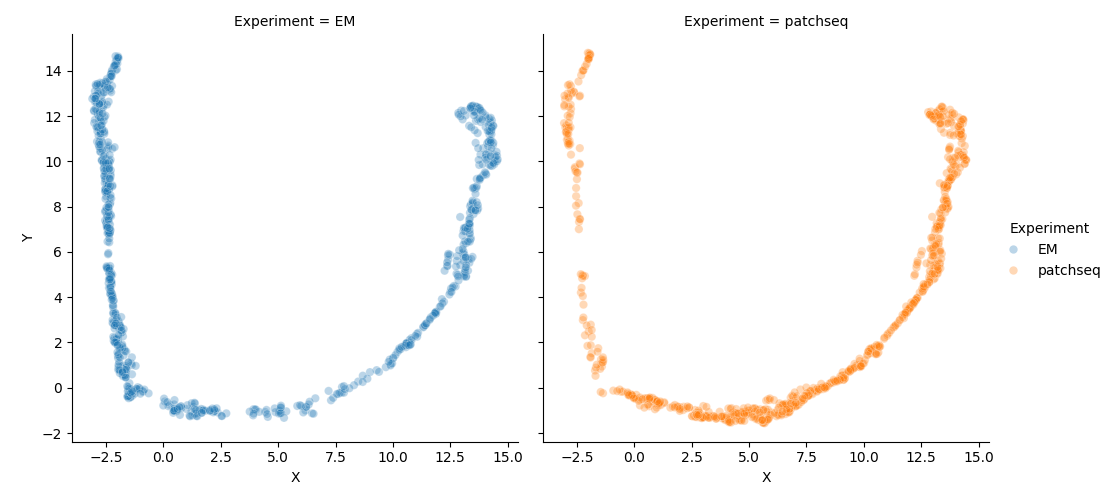

In [170]:
%matplotlib widget
plot = sns.relplot(
    data = {"X": proj_exc[:, 0], "Y": proj_exc[:, 1], "Experiment": anno_exc["platform"], "Type": anno_exc["class"]}, 
    x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

#### UMAP EM

In [162]:
umap_em = umap.UMAP().fit(arbors_em)
proj_em = umap_em.transform(arbors_exc)

/Users/ian.convy/miniconda3/envs/cpl/lib/python3.8/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


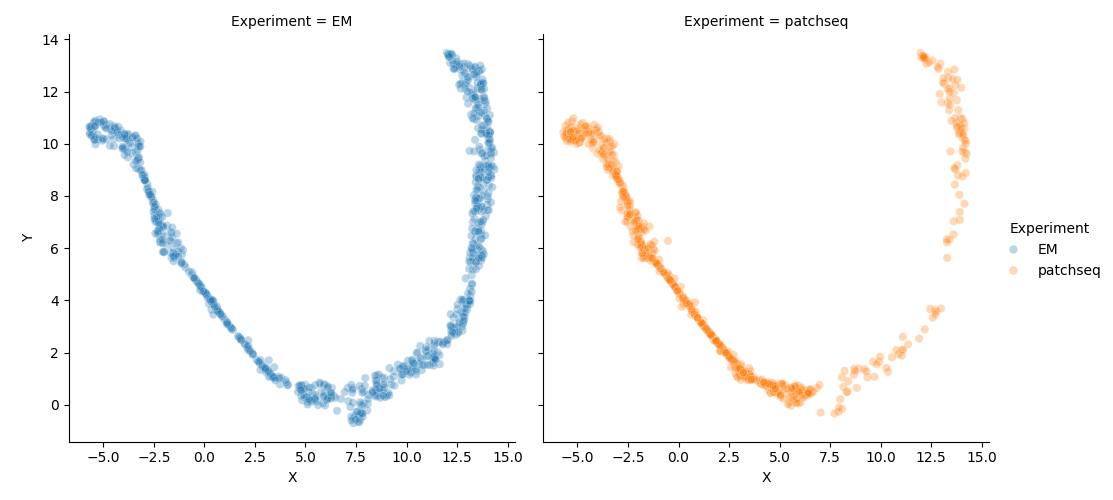

In [163]:
%matplotlib widget
plot = sns.relplot(
    data = {"X": proj_em[:, 0], "Y": proj_em[:, 1], "Experiment": anno_exc["platform"], "Type": anno_exc["class"]}, 
    x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

#### UMAP Patch-seq

In [42]:
umap_patch = umap.UMAP().fit(arbors_patch)
proj_patch = umap_patch.transform(arbors_exc)

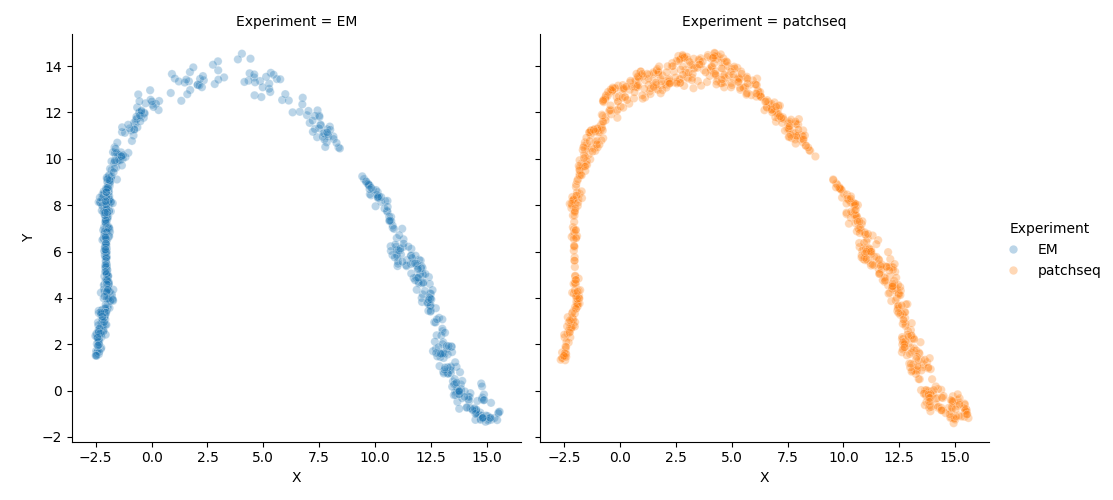

In [43]:
%matplotlib widget
plot = sns.relplot(
    data = {"X": proj_patch[:, 0], "Y": proj_patch[:, 1], "Experiment": anno_exc["platform"], "Type": anno_exc["class"]}, 
    x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

#### PCA EM + Patch-seq

In [235]:
pca_exc = PCA(2).fit(arbors_exc)
components_exc = pca_exc.transform(arbors_exc)

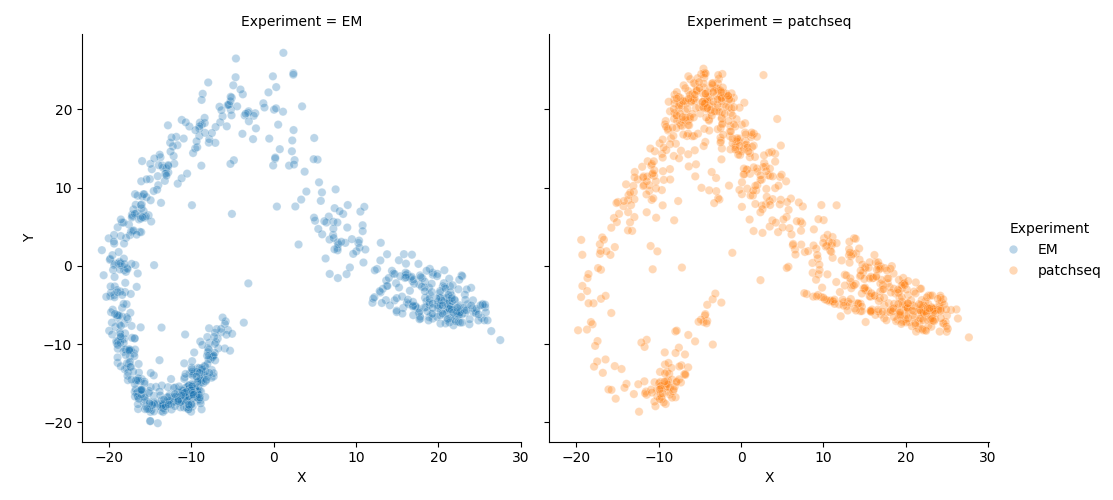

In [236]:
%matplotlib widget
plot = sns.relplot(data = {"X": components_exc[:, 0], "Y": components_exc[:, 1], "Experiment": anno_exc["platform"]}, 
                   x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

#### PCA EM

In [54]:
pca_em = PCA(2).fit(arbors_em)
components_em = pca_em.transform(arbors_exc)

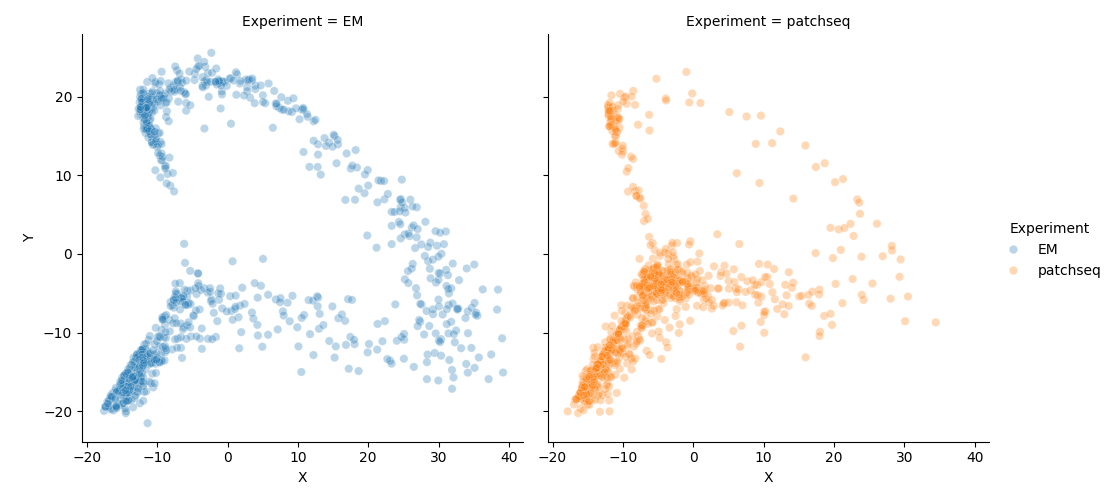

In [137]:
%matplotlib widget
plot = sns.relplot(data = {"X": components_em[:, 0], "Y": components_em[:, 1], "Experiment": anno_exc["platform"]},
                    x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

#### PCA Patch-seq

In [58]:
pca_patch = PCA(2).fit(arbors_patch)
components_patch = pca_patch.transform(arbors_exc)

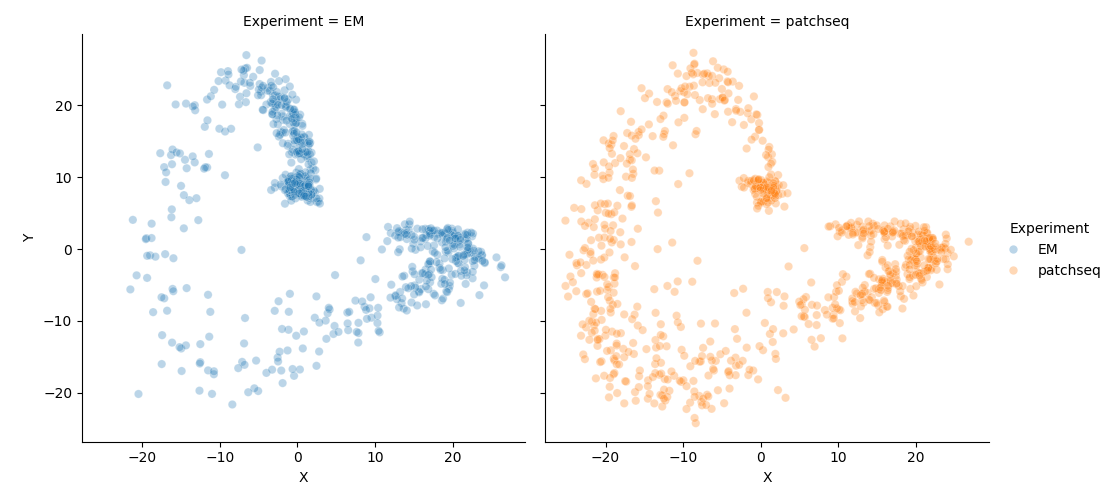

In [136]:
%matplotlib widget
plot = sns.relplot(data = {"X": components_patch[:, 0], "Y": components_patch[:, 1], "Experiment": anno_exc["platform"]},
                    x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

### Morphology Auto-encoder

In [64]:
latent_dict = np.load("../data/remote/morpho/reference_3d/outputs.npz")
specimen_ids = latent_dict["specimen_ids"]
latent = align(latent_dict["latent_space"], latent_dict["specimen_ids"], anno_full)
latent_exc = select(latent, anno_exc)

#### Latent Space

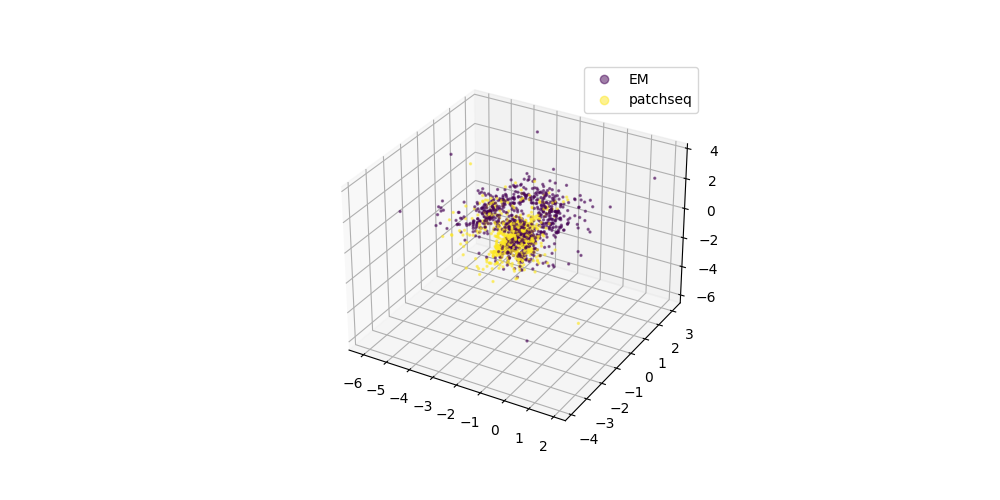

In [72]:
%matplotlib widget
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1, projection = "3d")
(factors_exp, labels_exp) = anno_exc["platform"].factorize() # For legend to match color with label
sc = ax.scatter(latent_exc[:, 0], latent_exc[:, 1], latent_exc[:, 2], s = 2, alpha = 0.5, 
                c = factors_exp)
leg = ax.legend(sc.legend_elements()[0], labels_exp.to_list())
plt.show()

#### UMAP of Latent Space

In [67]:
proj_latent = umap.UMAP().fit_transform(latent_exc)

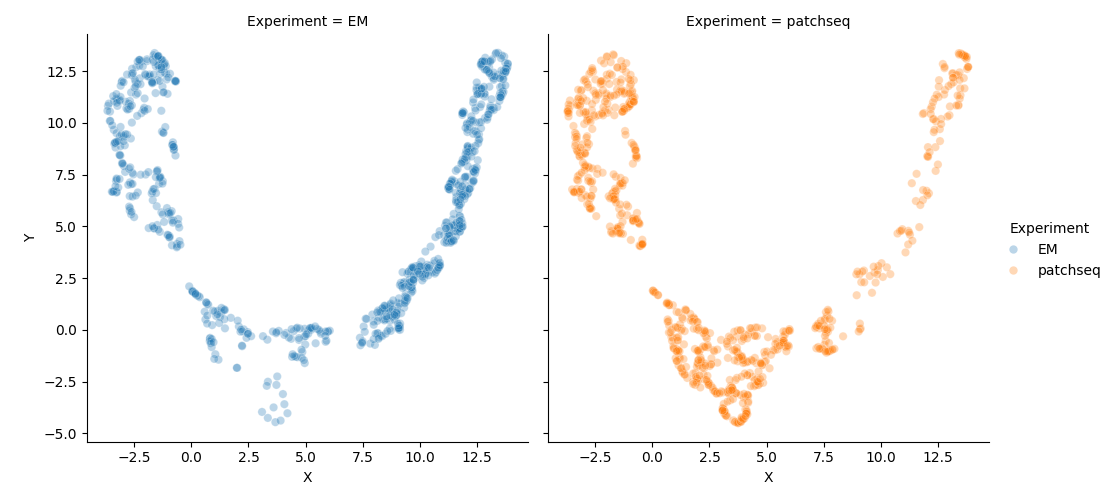

In [71]:
%matplotlib widget
plot = sns.relplot(data = {"X": proj_latent[:, 0], "Y": proj_latent[:, 1], "Experiment": anno_exc["platform"], 
                           "Type": anno_exc["class"]}, x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

### Coupled Auto-encoders

#### MET Coupled Auto-encoder 13k

In [129]:
with open("../data/remote/fahimeh/test_bayes/Results_trial_0.pkl", "rb") as target:
    outputs_coupled_13k = pk.load(target)
zm_13k_raw = outputs_coupled_13k["zm"]
valid_13k = outputs_coupled_13k["is_m_1d"]
anno_13k = anno_full[anno_full["specimen_id"].isin(outputs_coupled_13k["specimen_id"][valid_13k])]
(_, anno_13k_exc_inh) = normalize_sample_count("EM", "patchseq", anno_13k)
anno_13k_exc = anno_13k_exc_inh.query("`class` == 'exc'")
zm_13k = align(outputs_coupled_13k["zm"], outputs_coupled_13k["specimen_id"], anno_full)
zm_13k_exc = select(zm_13k, anno_13k_exc)

In [131]:
umap_13k = umap.UMAP(n_components = 2).fit(zm_13k_exc)
proj_13k = umap_13k.transform(zm_13k_exc)

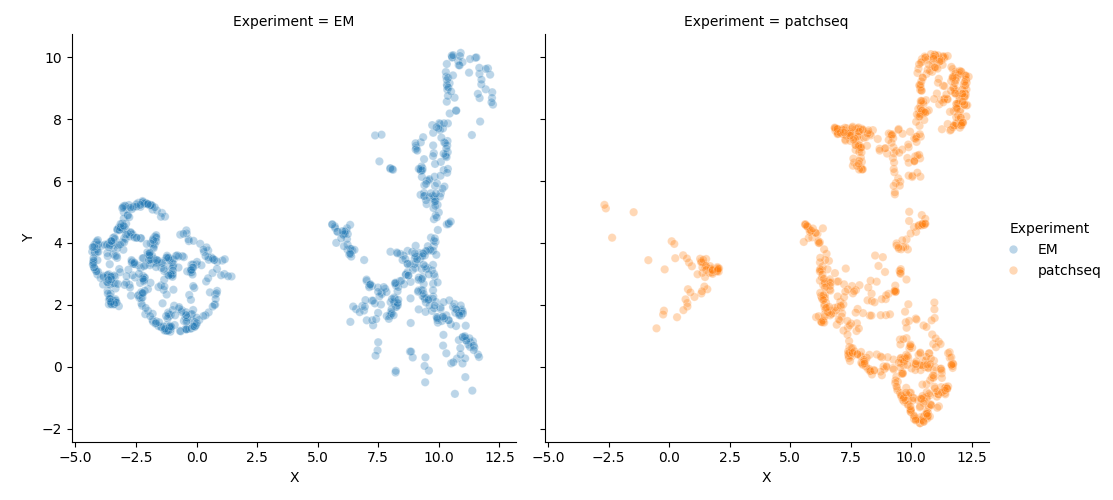

In [135]:
%matplotlib widget
plot = sns.relplot(data = {"X": proj_13k[:, 0], "Y": proj_13k[:, 1], "Experiment": anno_13k_exc["platform"]}, 
                           x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

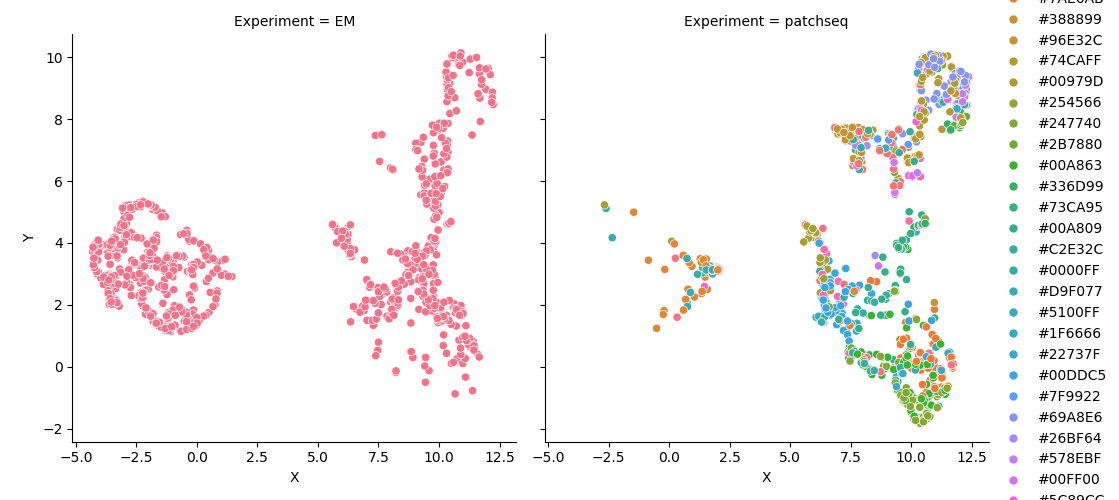

In [144]:
cluster_color = select(align(outputs_coupled_13k["cluster_color"], outputs_coupled_13k["specimen_id"], anno_full), anno_13k_exc)
%matplotlib widget
plot = sns.relplot(data = {"X": proj_13k[:, 0], "Y": proj_13k[:, 1], "Experiment": anno_13k_exc["platform"], "Types": cluster_color}, 
                           x = "X", y = "Y", hue = "Types", col = "Experiment")
plt.show()

#### MET Coupled Auto-encoder 50k

In [211]:
with open("../data/remote/fahimeh/test_50k_3d/Results_trial_0.pkl", "rb") as target:
    outputs_coupled_50k = pk.load(target)
zm_50k_raw = outputs_coupled_50k["zm"]
valid_50k = outputs_coupled_50k["is_m_1d"]
anno_50k = anno_full[anno_full["specimen_id"].isin(outputs_coupled_50k["specimen_id"][valid_50k])]
(_, anno_50k_exc_inh) = normalize_sample_count("EM", "patchseq", anno_50k)
anno_50k_exc = anno_50k_exc_inh.query("`class` == 'exc'")
zm_50k = align(outputs_coupled_50k["zm"], outputs_coupled_50k["specimen_id"], anno_full)
zm_50k_exc = select(zm_50k, anno_50k_exc)

In [466]:
outputs_coupled_50k["val_ind"].shape

(122,)

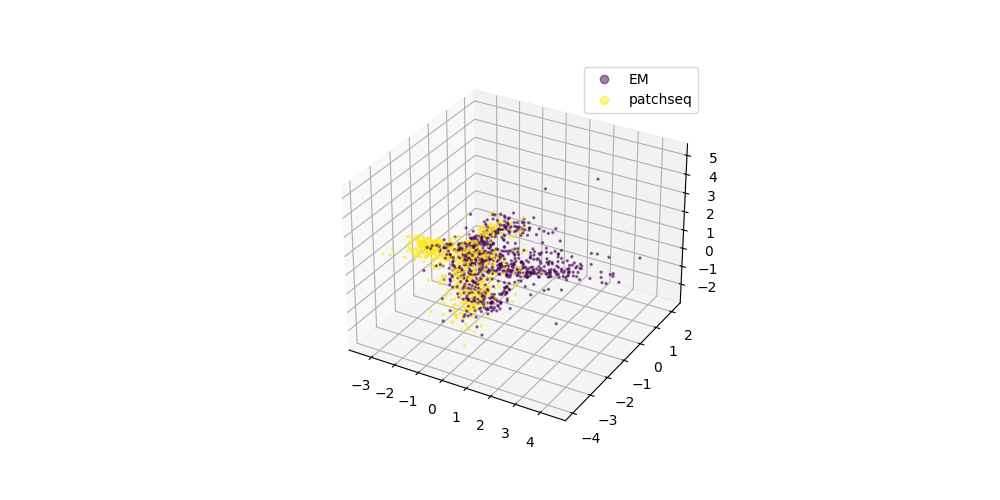

In [224]:
%matplotlib widget
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1, projection = "3d")
(factors_exp, labels_exp) = anno_50k_exc["platform"].factorize() # For legend to match color with label
sc = ax.scatter(zm_50k_exc[:, 0], zm_50k_exc[:, 1], zm_50k_exc[:, 2], s = 2, alpha = 0.5, 
                c = factors_exp)
leg = ax.legend(sc.legend_elements()[0], labels_exp.to_list())
plt.show()

In [206]:
umap_50k = umap.UMAP(n_components = 2).fit(zm_50k_exc)
proj_50k = umap_50k.transform(zm_50k_exc)

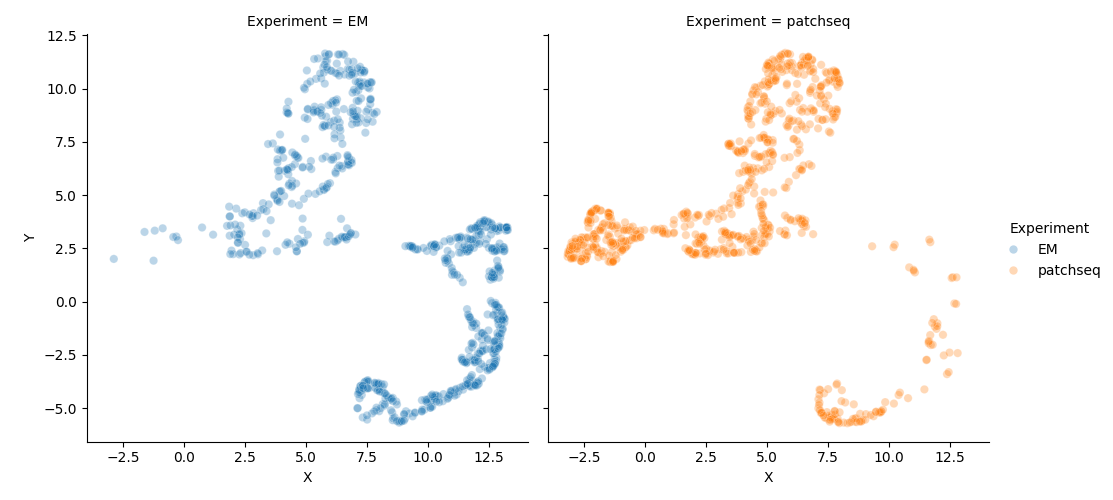

In [207]:
%matplotlib widget
plot = sns.relplot(data = {"X": proj_50k[:, 0], "Y": proj_50k[:, 1], "Experiment": anno_50k_exc["platform"]}, 
                           x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3)
plt.show()

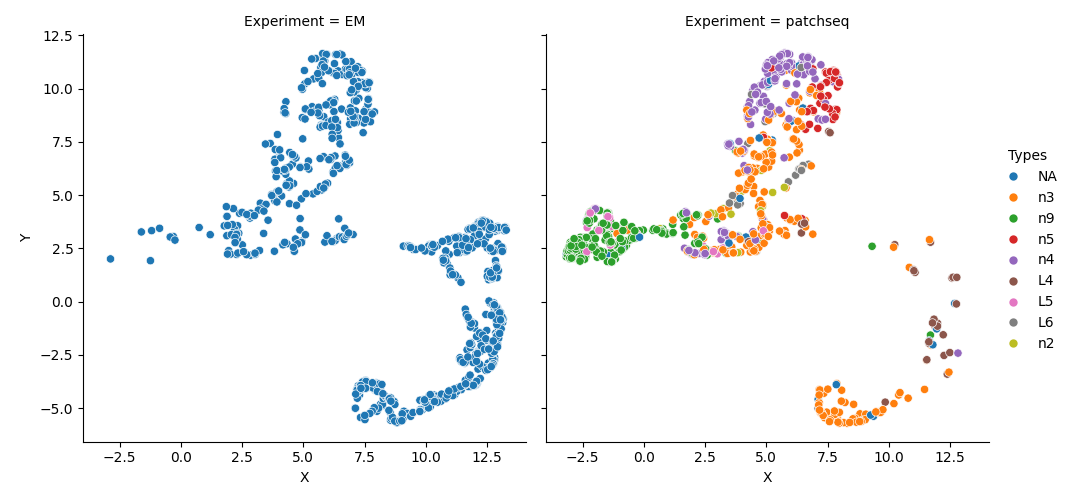

In [454]:
cluster_color = select(align(outputs_coupled_50k["merged_cluster_label_at50"], outputs_coupled_50k["specimen_id"], anno_full), anno_50k_exc)
%matplotlib widget
plot = sns.relplot(data = {"X": proj_50k[:, 0], "Y": proj_50k[:, 1], "Experiment": anno_50k_exc["platform"], "Types": cluster_color}, 
                           x = "X", y = "Y", hue = "Types", col = "Experiment")
plt.show()

#### T-Arm

In [210]:
with open("../data/remote/fahimeh/test_50k_3d/Results_trial_0.pkl", "rb") as target:
    outputs = pk.load(target)

In [220]:
zt_all = outputs_coupled_50k["zt"]
val = outputs_coupled_50k["is_t_1d"]
an = anno_full[anno_full["specimen_id"].isin(outputs["specimen_id"][val])].query("`class` == 'exc'")
zt_raw = align(zt_all, outputs["specimen_id"], anno_full)
zt = select(zt_raw, an)

In [221]:
umap_t = umap.UMAP(n_components = 2).fit(zt)
proj_t = umap_t.transform(zt)

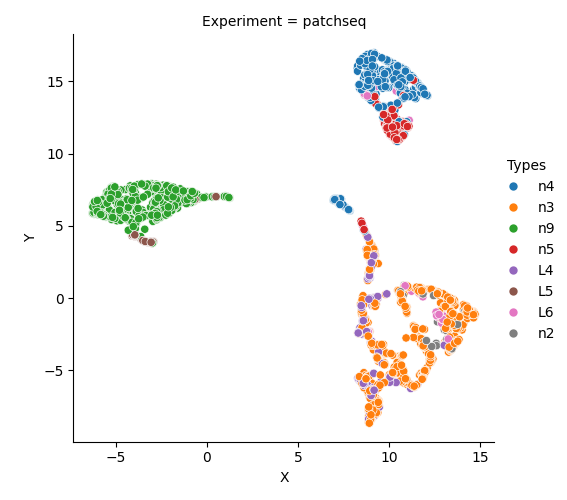

In [455]:
cluster_color = select(align(outputs["merged_cluster_label_at50"], outputs["specimen_id"], anno_full), an)
%matplotlib widget
plot = sns.relplot(data = {"X": proj_t[:, 0], "Y": proj_t[:, 1], "Experiment": an["platform"], "Types": cluster_color}, 
                           x = "X", y = "Y", hue = "Types", col = "Experiment")
plt.show()

### Adversarial Alignment

#### Setup

In [147]:
class Aligner(torch.nn.Module):
    def __init__(self, hidden_dims, activation):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.layer_names = []
        all_dims = [960] + list(hidden_dims) + [960]
        for (i, (in_dim, out_dim)) in enumerate(zip(all_dims[:-1], all_dims[1:]), 1):
            setattr(self, f"l{i}", torch.nn.Linear(in_dim, out_dim))
            self.layer_names.append(f"l{i}")
        self.relu = torch.nn.ReLU()
        if activation == "linear":
            self.activation = torch.nn.Identity()
        elif activation == "relu":
            self.activation = torch.nn.functional.relu
        elif activation == "softplus":
            self.activation = torch.nn.functional.softplus
        else:
            raise ValueError(f'Activation "{activation}" not recognized.')

    def forward(self, X):
        for layer_name in self.layer_names[:-1]:
            layer = getattr(self, layer_name)
            X = self.relu(layer(X))
        final_layer = getattr(self, self.layer_names[-1])
        output = self.activation(final_layer(X))
        return output

In [371]:
aligner = Aligner([100], "softplus")
aligner.load_state_dict(torch.load("../data/align/shallow_id_saved/aligner_best_params.pt", map_location = torch.device("cpu")))

<All keys matched successfully>

In [372]:
spec_ids = np.load("../data/align/shallow_id_saved/specimen_ids.npz", allow_pickle = True)
(em_train_ids, patch_train_ids) = (spec_ids["em_train"], spec_ids["patch_train"])

In [373]:
X_train_em = select(flat_arbors, anno[anno["specimen_id"].isin(em_train_ids)])
X_train_patch = select(flat_arbors, anno[anno["specimen_id"].isin(patch_train_ids)])

In [374]:
arbors_aligned = aligner(torch.from_numpy(X_train_patch).float()).detach().cpu().numpy()

In [391]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

#### Training Accuracy

In [392]:
X_orig = np.concatenate([X_train_em, X_train_patch])
X_aligned = np.concatenate([X_train_em, arbors_aligned])
y = np.concatenate([-np.ones([X_train_em.shape[0]]), np.ones([X_train_patch.shape[0]])])
(orig_train, orig_test, aligned_train, aligned_test, y_train, y_test) = train_test_split(
    X_orig, X_aligned, y, test_size = 1 / 6, random_state = 42)

In [388]:
ridge_orig = RidgeClassifier(alpha = 5).fit(orig_train, y_train).score(orig_test, y_test)
ridge_aligned = RidgeClassifier(alpha = 5).fit(aligned_train, y_train).score(aligned_test, y_test)

In [395]:
mlp_orig = MLPClassifier((100,)).fit(orig_train, y_train).score(orig_test, y_test)
mlp_aligned = MLPClassifier((100,), max_iter = 1000).fit(aligned_train, y_train).score(aligned_test, y_test)

In [397]:
print("Linear Classifier")
print(f"Original: {100*ridge_orig:.2f} | Aligned: {100*ridge_aligned:.2f}\n")
print("Neural Network Classifier")
print(f"Original: {100*mlp_orig:.2f} | Aligned: {100*mlp_aligned:.2f}")

Linear Classifier
Original: 82.69 | Aligned: 61.06

Neural Network Classifier
Original: 87.02 | Aligned: 50.00


#### Projections

In [381]:
proj_em_train = umap_exc.transform(X_train_em)
proj_patch_train = umap_exc.transform(X_train_patch)
proj_aligned = umap_exc.transform(arbors_aligned)

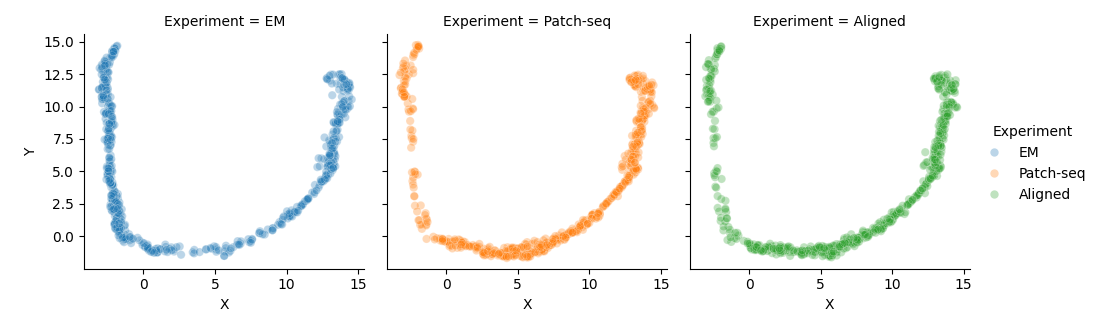

In [382]:
%matplotlib widget
plot = sns.relplot(
    data = {"X": np.concatenate([proj_em_train[:, 0], proj_patch_train[:, 0], proj_aligned[:, 0]]), 
            "Y": np.concatenate([proj_em_train[:, 1], proj_patch_train[:, 1], proj_aligned[:, 1]]), 
            "Experiment": np.concatenate([np.full(proj_em_train.shape[0], "EM"), np.full(proj_patch_train.shape[0], "Patch-seq"), np.full(proj_aligned.shape[0], "Aligned")])}, 
    x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3, height=3.27, aspect= 1)
plt.show()

In [383]:
comp_em_train = pca_exc.transform(X_train_em)
comp_patch_train = pca_exc.transform(X_train_patch)
comp_aligned = pca_exc.transform(arbors_aligned)

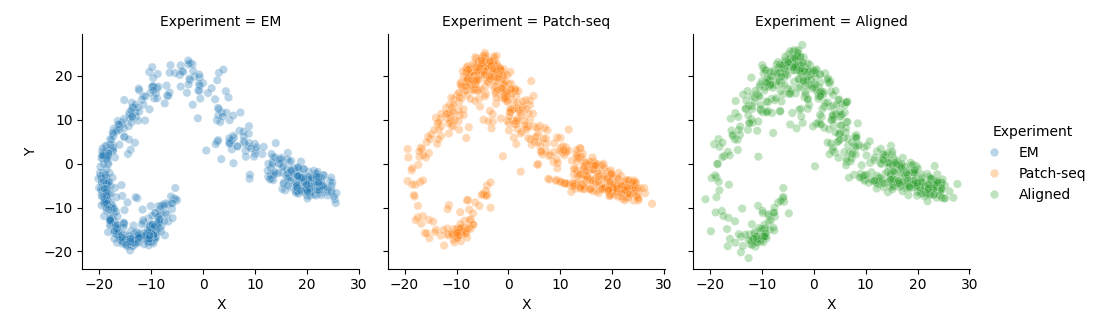

In [384]:
%matplotlib widget
plot = sns.relplot(
    data = {"X": np.concatenate([comp_em_train[:, 0], comp_patch_train[:, 0], comp_aligned[:, 0]]), 
            "Y": np.concatenate([comp_em_train[:, 1], comp_patch_train[:, 1], comp_aligned[:, 1]]), 
            "Experiment": np.concatenate([np.full(comp_em_train.shape[0], "EM"), np.full(comp_patch_train.shape[0], "Patch-seq"), np.full(comp_aligned.shape[0], "Aligned")])}, 
    x = "X", y = "Y", hue = "Experiment", col = "Experiment", alpha = 0.3, height=3.27, aspect= 1)
plt.show()

#### Feature Plots

##### Single Sample

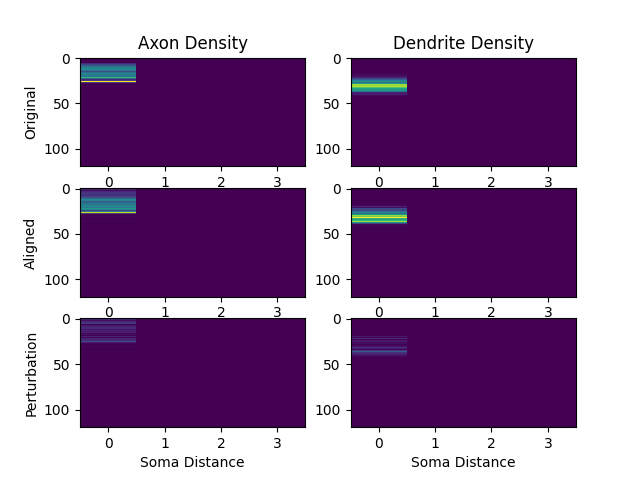

In [460]:
(fig, axes) = plt.subplots(3, 2)
largest_1 = max(X_train_patch.reshape(-1, 120, 4, 2)[0, ..., 0].max(), arbors_aligned.reshape(-1, 120, 4, 2)[0, ..., 0].max(), abs(arbors_aligned - X_train_patch).reshape(-1, 120, 4, 2)[0, ..., 0].max())
largest_2 = max(X_train_patch.reshape(-1, 120, 4, 2)[0, ..., 1].max(), arbors_aligned.reshape(-1, 120, 4, 2)[0, ..., 1].max(), abs(arbors_aligned - X_train_patch).reshape(-1, 120, 4, 2)[0, ..., 1].max())
axes[0][0].imshow(X_train_patch.reshape(-1, 120, 4, 2)[0, ..., 0], aspect = "auto", interpolation = "None", vmax = largest_1)
axes[0][1].imshow(X_train_patch.reshape(-1, 120, 4, 2)[0, ..., 1], aspect = "auto", interpolation = "None", vmax = largest_2)
axes[1][0].imshow(arbors_aligned.reshape(-1, 120, 4, 2)[0, ..., 0], aspect = "auto", interpolation = "None", vmax = largest_1)
axes[1][1].imshow(arbors_aligned.reshape(-1, 120, 4, 2)[0, ..., 1], aspect = "auto", interpolation = "None", vmax = largest_2)
axes[2][0].imshow(abs(arbors_aligned - X_train_patch).reshape(-1, 120, 4, 2)[0, ..., 0], aspect = "auto", interpolation = "None", vmax = largest_1)
axes[2][1].imshow(abs(arbors_aligned - X_train_patch).reshape(-1, 120, 4, 2)[0, ..., 1], aspect = "auto", interpolation = "None", vmax = largest_2)

axes[0][0].set_title("Axon Density")
axes[0][1].set_title("Dendrite Density")
axes[0][0].set_ylabel("Original")
axes[1][0].set_ylabel("Aligned")
axes[2][0].set_ylabel("Perturbation")
axes[2][0].set_xlabel("Soma Distance")
axes[2][1].set_xlabel("Soma Distance")

plt.show()

In [434]:
sample_umap = umap_exc.transform(X_train_patch[:1])[0]
sample_aligned_umap = umap_exc.transform(arbors_aligned[:1])[0]
sample_pca = pca_exc.transform(X_train_patch[:1])[0]
sample_aligned_pca = pca_exc.transform(arbors_aligned[:1])[0]

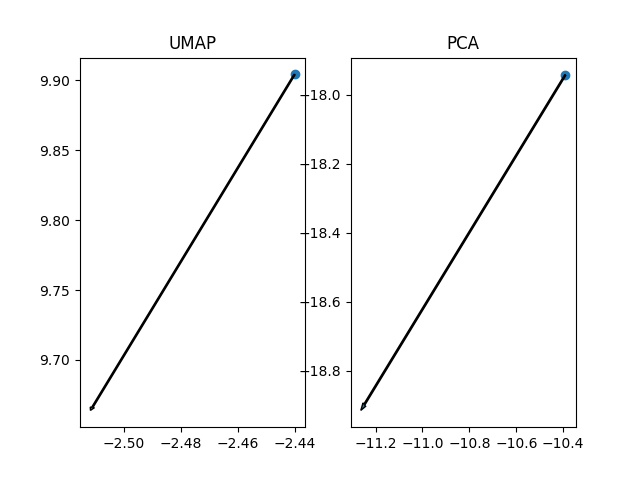

In [442]:
(fig, (ax_umap, ax_pca)) = plt.subplots(1, 2)
ax_umap.scatter(sample_umap[0], sample_umap[1])
ax_umap.arrow(sample_umap[0], sample_umap[1], sample_aligned_umap[0] - sample_umap[0], sample_aligned_umap[1] - sample_umap[1], width = 0.0005)
ax_pca.scatter(sample_pca[0], sample_pca[1])
ax_pca.arrow(sample_pca[0], sample_pca[1], sample_aligned_pca[0] - sample_pca[0], sample_aligned_pca[1] - sample_pca[1], width = 0.005)
ax_umap.set_title("UMAP")
ax_pca.set_title("PCA")
plt.show()

#### Averages

In [443]:
em_mean = X_train_em.mean(0).reshape(120, 4, 2)
patch_mean = X_train_patch.mean(0).reshape(120, 4, 2)
aligned_mean = arbors_aligned.mean(0).reshape(120, 4, 2)
pert = (arbors_aligned - X_train_patch).mean(0).reshape(120, 4, 2)

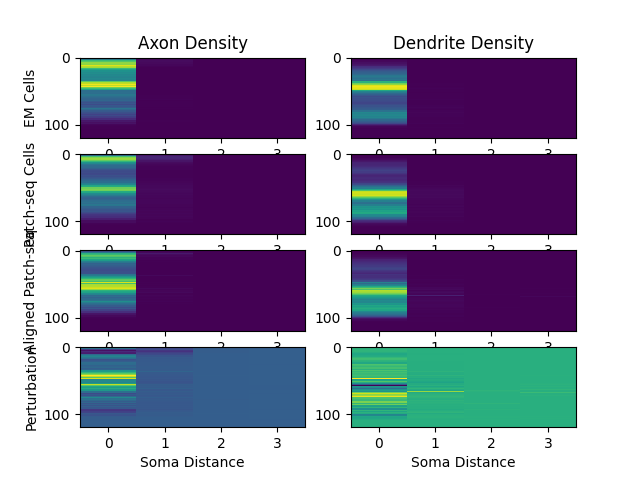

In [457]:
%matplotlib widget
largest_1 = max(em_mean[..., 0].max(), patch_mean[..., 0].max(), aligned_mean[..., 0].max())
largest_2 = max(em_mean[..., 1].max(), patch_mean[..., 1].max(), aligned_mean[..., 1].max())
(fig, axes) = plt.subplots(4, 2)
axes[0][0].imshow(em_mean[..., 0], aspect = "auto", interpolation = "None", vmax = largest_1)
axes[0][1].imshow(em_mean[..., 1], aspect = "auto", interpolation = "None", vmax = largest_2)
axes[1][0].imshow(patch_mean[..., 0], aspect = "auto", interpolation = "None", vmax = largest_1)
axes[1][1].imshow(patch_mean[..., 1], aspect = "auto", interpolation = "None", vmax = largest_2)
axes[2][0].imshow(aligned_mean[..., 0], aspect = "auto", interpolation = "None", vmax = largest_1)
axes[2][1].imshow(aligned_mean[..., 1], aspect = "auto", interpolation = "None", vmax = largest_2)
axes[3][0].imshow(pert[..., 0], aspect = "auto", interpolation = "None")
axes[3][1].imshow(pert[..., 1], aspect = "auto", interpolation = "None")

axes[0][0].set_title("Axon Density")
axes[0][1].set_title("Dendrite Density")
axes[0][0].set_ylabel("EM Cells")
axes[1][0].set_ylabel("Patch-seq Cells")
axes[2][0].set_ylabel("Aligned Patch-seq")
axes[3][0].set_ylabel("Perturbation")
axes[3][0].set_xlabel("Soma Distance")
axes[3][1].set_xlabel("Soma Distance")

plt.show()